In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
from collections import defaultdict

base_folder = Path("../outputs/experiments/continual_learning").resolve()
cl_folder = base_folder / "continual_mitigation"

sns.set(context="paper", style="white", font_scale=2.5, palette="tab10")

In [2]:
def load_results(folder):
    results = {}
    for path in folder.glob("*.csv"):
        df = pd.read_csv(path, index_col=0)
        if 'toxicity' in path.name:
            if 'groupby' in path.name:
                df = pd.read_csv(path, header=[0, 1], index_col=0)
                df = df.T.reset_index(names=["mode", "domain_result"]).melt(
                    id_vars=["mode", "domain_result"],
                    value_vars=["avg_max", "toxicity_probability", "std_max"],
                    var_name="metric"
                ).query("metric != 'std_max'")
                df["metric"] = df["metric"].map(
                    {"avg_max": "Expected Maximum Toxicity", "toxicity_probability": "Toxicity Probability"}
                )
                results['toxicity_gb'] = df.copy()
            else:
                df = df.reset_index().melt(
                    id_vars="index", value_name="value", var_name="mode"
                ).rename({'index': 'metric'}, axis=1).query("metric != 'std_max'").copy()

                df["metric"] = df["metric"].map(
                    {"avg_max": "Expected Maximum Toxicity", "toxicity_probability": "Toxicity Probability"}
                )
                results['toxicity'] = df.copy()
            
        else:
            df = df.melt(var_name="mode", value_name="value")

            if 'perplexity' in path.name:
                results['ppl'] = df.copy()
            elif 'diversity' in path.name:
                results['diversity'] = df.copy()
    return results

def get_metrics(exp_path, baseline=False):
    results_dfs = defaultdict(lambda: pd.DataFrame())

    if baseline:
        domain_results = load_results(exp_path)

        for rtp, results in zip([False], [domain_results]):
            for metric, df in results.items():
                df["domain"] = "baseline"
                df["domain_idx"] = -1
                df["RTP"] = rtp
                results_dfs[metric] = pd.concat([results_dfs[metric], df], axis=0).reset_index(drop=True)

        return results_dfs

    ds_added = [sub.name for sub in exp_path.iterdir()]
    for ds in ds_added:
        # TODO add this ds_added to the dataframe if required
        domains_folders = [sub.name for sub in sorted((exp_path / ds).iterdir()) if not 'logs' in sub.name]
        for domain_folder in domains_folders:
            idx, domain_name = domain_folder.split("=")[-1].split("-")        
            round_path = exp_path / ds / domain_folder

            domain_results = load_results(round_path)
            rtp_results = load_results(round_path / "RTP")

            for rtp, results in zip([False, True], [domain_results, rtp_results]):
                for metric, df in results.items():
                    df["domain"] = domain_name
                    df["domain_idx"] = int(idx)
                    df["RTP"] = rtp
                    results_dfs[metric] = pd.concat([results_dfs[metric], df], axis=0).reset_index(drop=True)

    return results_dfs

def get_experiment_results(experiments, baselines=False):
    metrics_df = defaultdict(lambda: pd.DataFrame())
    for name, path in experiments.items():
        try:
            curr_metrics = get_metrics(path, baselines)
            for metric in curr_metrics.keys():
                curr_metrics[metric]["experiment"] = name
                metrics_df[metric] = pd.concat([metrics_df[metric], curr_metrics[metric]])
        except FileNotFoundError:
            pass
    return metrics_df

In [3]:
experiments = {
    "Goodtriever": cl_folder / "clustered/toxic_adaptation/12345/gpt2-large/knn",
    "DExperts (Multitask)": cl_folder / "clustered/toxic_adaptation/12345/dexperts/multitask_finetune/gpt2-large/dexperts",
    "DExperts (Continual)": cl_folder / "clustered/toxic_adaptation/12345/dexperts/continual_finetune/gpt2-large/dexperts"
}
baselines = {
    "GPT2 (large)": cl_folder /  "clustered/toxic_adaptation/baselines/gpt2-large",
    "DExperts (large)": cl_folder / "clustered/toxic_adaptation/baselines/dexperts-large",
    "Goodtriever (large)": cl_folder / "clustered/toxic_adaptation/baselines/goodtriever-large"
}
goodtriever_runs = {
    "12345": cl_folder / "clustered/toxic_adaptation/12345/gpt2-large/knn",
    "54321": cl_folder / "clustered/toxic_adaptation/54321/gpt2-large/knn",
    "35142": cl_folder / "clustered/toxic_adaptation/35142/gpt2-large/knn",
}

metrics_df = get_experiment_results(experiments)
baselines_df = get_experiment_results(baselines, baselines=True)
goodtriever_df = get_experiment_results(goodtriever_runs)

domains = {
    "1": "Politics",
    "2": "Muslims",
    "3": "Race",
    "4": "LGBTQ",
    "5": "Christians"
}

## Toxicity

In [4]:
baselines_df["toxicity"].query("mode == 'toxic'").sort_values(by=["metric", "value"], ascending=False).round(2)[["metric", "value", "experiment"]]

,metric,value,experiment
1,Toxicity Probability,0.70,GPT2 (large)
1,Toxicity Probability,0.10,Goodtriever (large)
1,Toxicity Probability,0.06,DExperts (large)
0,Expected Maximum Toxicity,0.63,GPT2 (large)
0,Expected Maximum Toxicity,0.33,Goodtriever (large)
0,Expected Maximum Toxicity,0.32,DExperts (large)


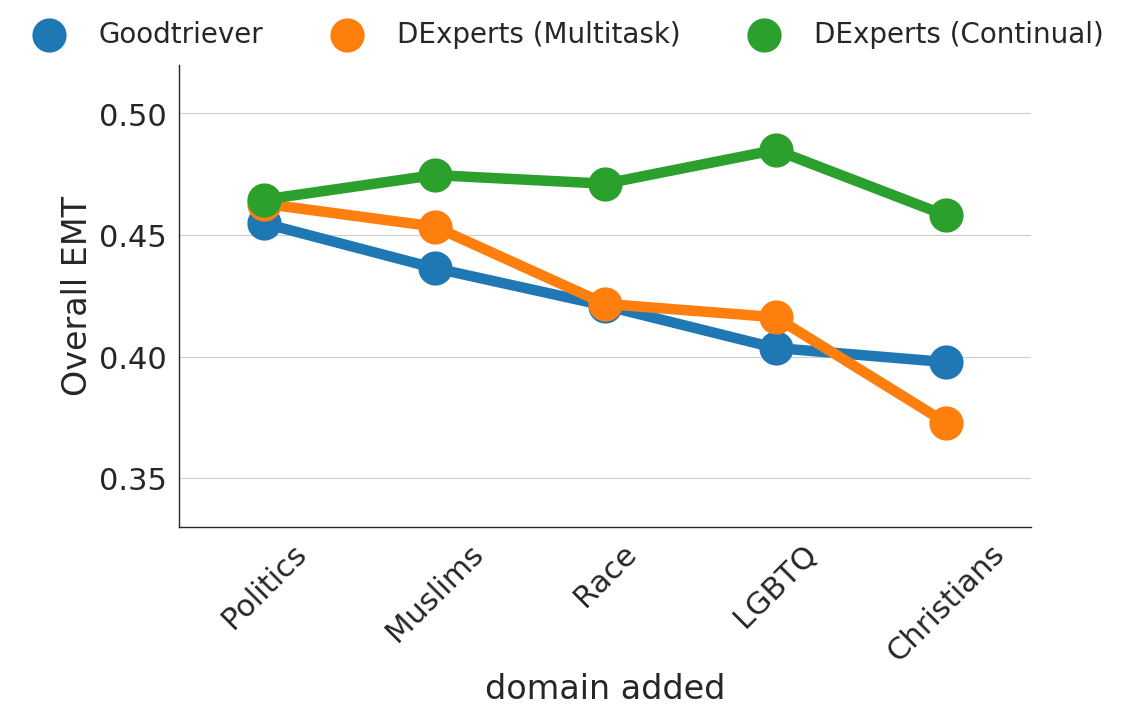

In [6]:
main_metric = "toxicity"
metric = "Expected Maximum Toxicity"

temp = metrics_df[main_metric].query("RTP == False and mode == 'toxic' and metric == @metric")
baseline = baselines_df[main_metric].query("mode == 'toxic' and metric == @metric")

plt.figure(figsize=(9, 5))
g = sns.pointplot(
    data=temp,
    x="domain_idx",
    y="value",
    linestyles="-",
    hue="experiment",
    scale=3.5,
)
# plt.title(f"Overall {metric}")
# plt.legend(title="Technique", bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.grid(axis="y")

plt.ylabel("Overall EMT")
plt.xlabel("domain added")
plt.xticks(labels=domains.values(), ticks=[0, 1, 2, 3, 4], rotation=45)
plt.ylim((0.33, 0.52))
sns.despine(right=True, top=True)
sns.move_legend(g, "upper center", ncols=3, fontsize=20, title="", frameon=False, bbox_to_anchor=(0.45, 1.15))

plt.savefig("../images/cl_techniques_overall.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Domain-specific toxicity results

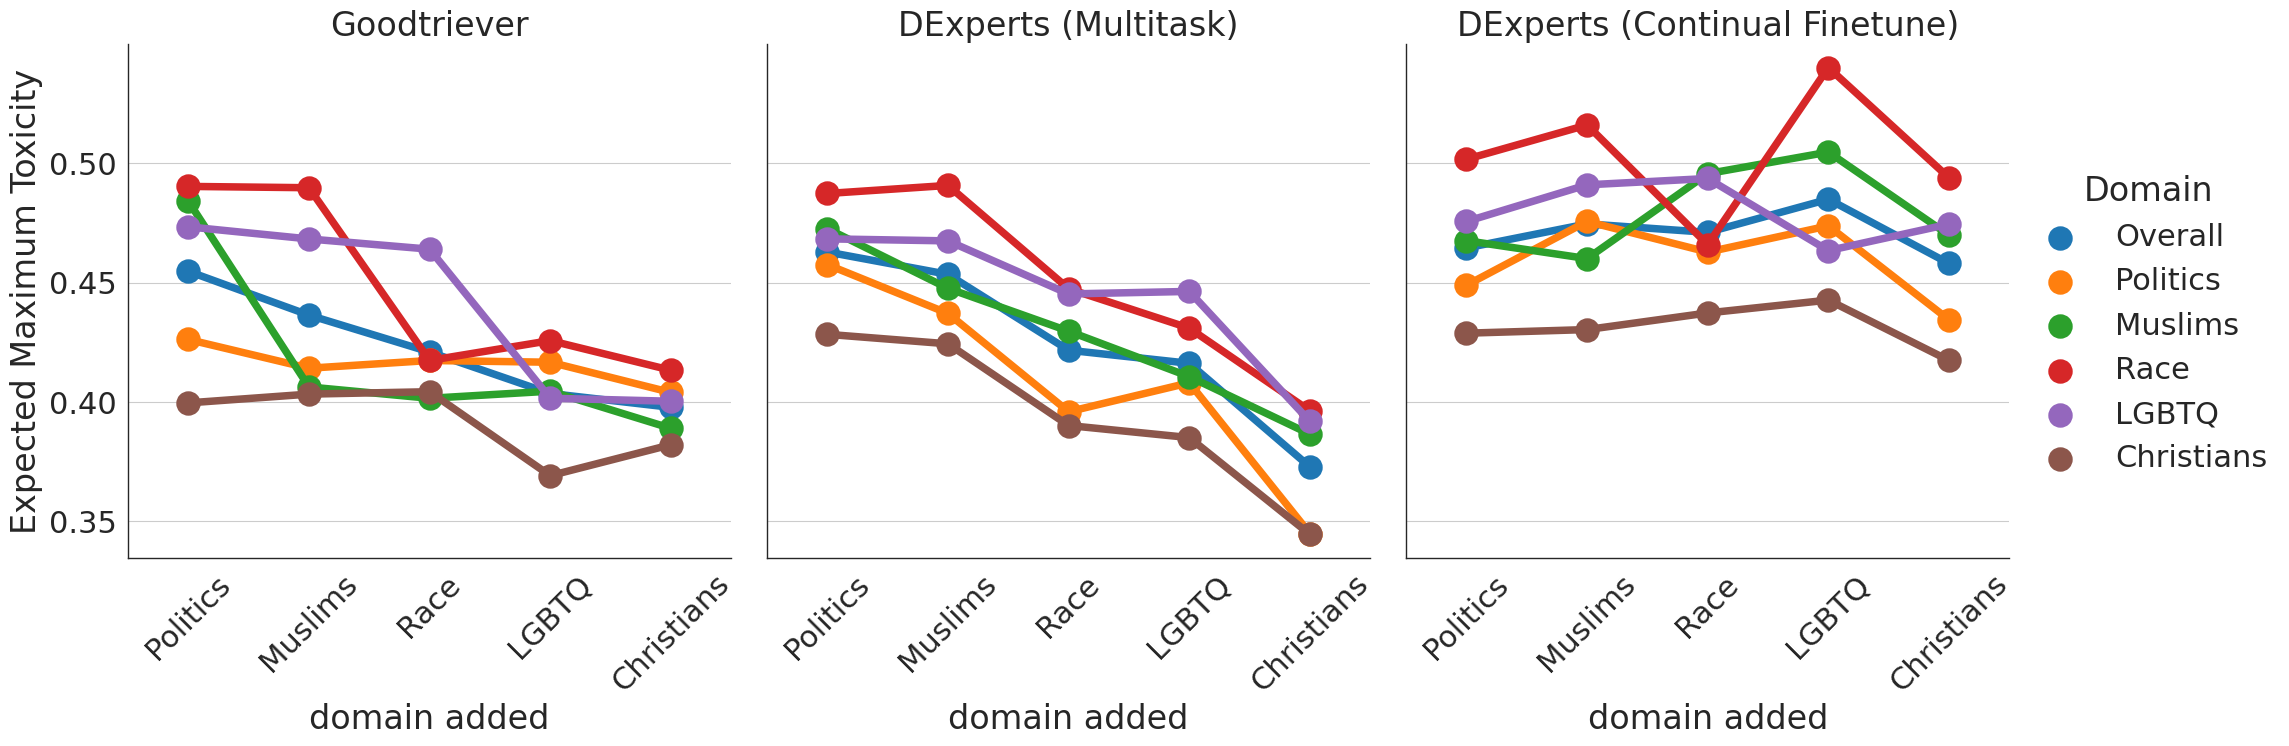

In [53]:
main_metric = "toxicity_gb"
metric = "Expected Maximum Toxicity"

overall = metrics_df["toxicity"].query("mode == 'toxic' and metric == @metric").copy()
overall["domain_result"] = "Overall"
temp = metrics_df[main_metric].query("mode == 'toxic' and metric == @metric")
temp = pd.concat([overall, temp])
temp["Domain"] = temp["domain_result"].map({"Overall": "Overall", **domains})

g = sns.catplot(
    data=temp,
    x="domain_idx",
    y="value",
    kind="point",
    hue="Domain",
    col="experiment",
    scale=2.5,
    height=7,
    aspect=1.0
)
g.set_titles("{col_name}")
for row_ax, domain in zip(g.axes, sorted(temp["Domain"].unique())):
    for idx, ax in enumerate(row_ax):
        ax.set_xticks(
            labels=domains.values(), 
            ticks=[0, 1, 2, 3, 4], 
            rotation=45
        )
        ax.set_xlabel("domain added")
        ax.set_ylabel(metric)
        ax.grid(axis="y")


#plt.suptitle(f"Domain-specific {metric}")
# sns.move_legend(g, "upper center", ncols=6, fontsize=14, title="Domain", bbox_to_anchor=(0.5, 1.1))
sns.move_legend(g, "center right", bbox_to_anchor=(1.0, 0.5))
plt.savefig("../images/cl_techniques.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../images/cl_techniques.svg", format="svg", bbox_inches="tight")
plt.show()

In [88]:
pd.pivot_table(temp.query("domain_idx == 4"), values="value", index=["experiment"], columns=["metric", "domain_result"]).round(2)

metric                        Expected Maximum Toxicity                    \
domain_result                                         1     2     3     4   
experiment                                                                  
DExperts (Continual Finetune)                      0.43  0.47  0.49  0.47   
DExperts (Multitask)                               0.34  0.39  0.40  0.39   
Goodtriever                                        0.40  0.39  0.41  0.40   

metric                                       
domain_result                     5 Overall  
experiment                                   
DExperts (Continual Finetune)  0.42    0.46  
DExperts (Multitask)           0.34    0.37  
Goodtriever                    0.38    0.40

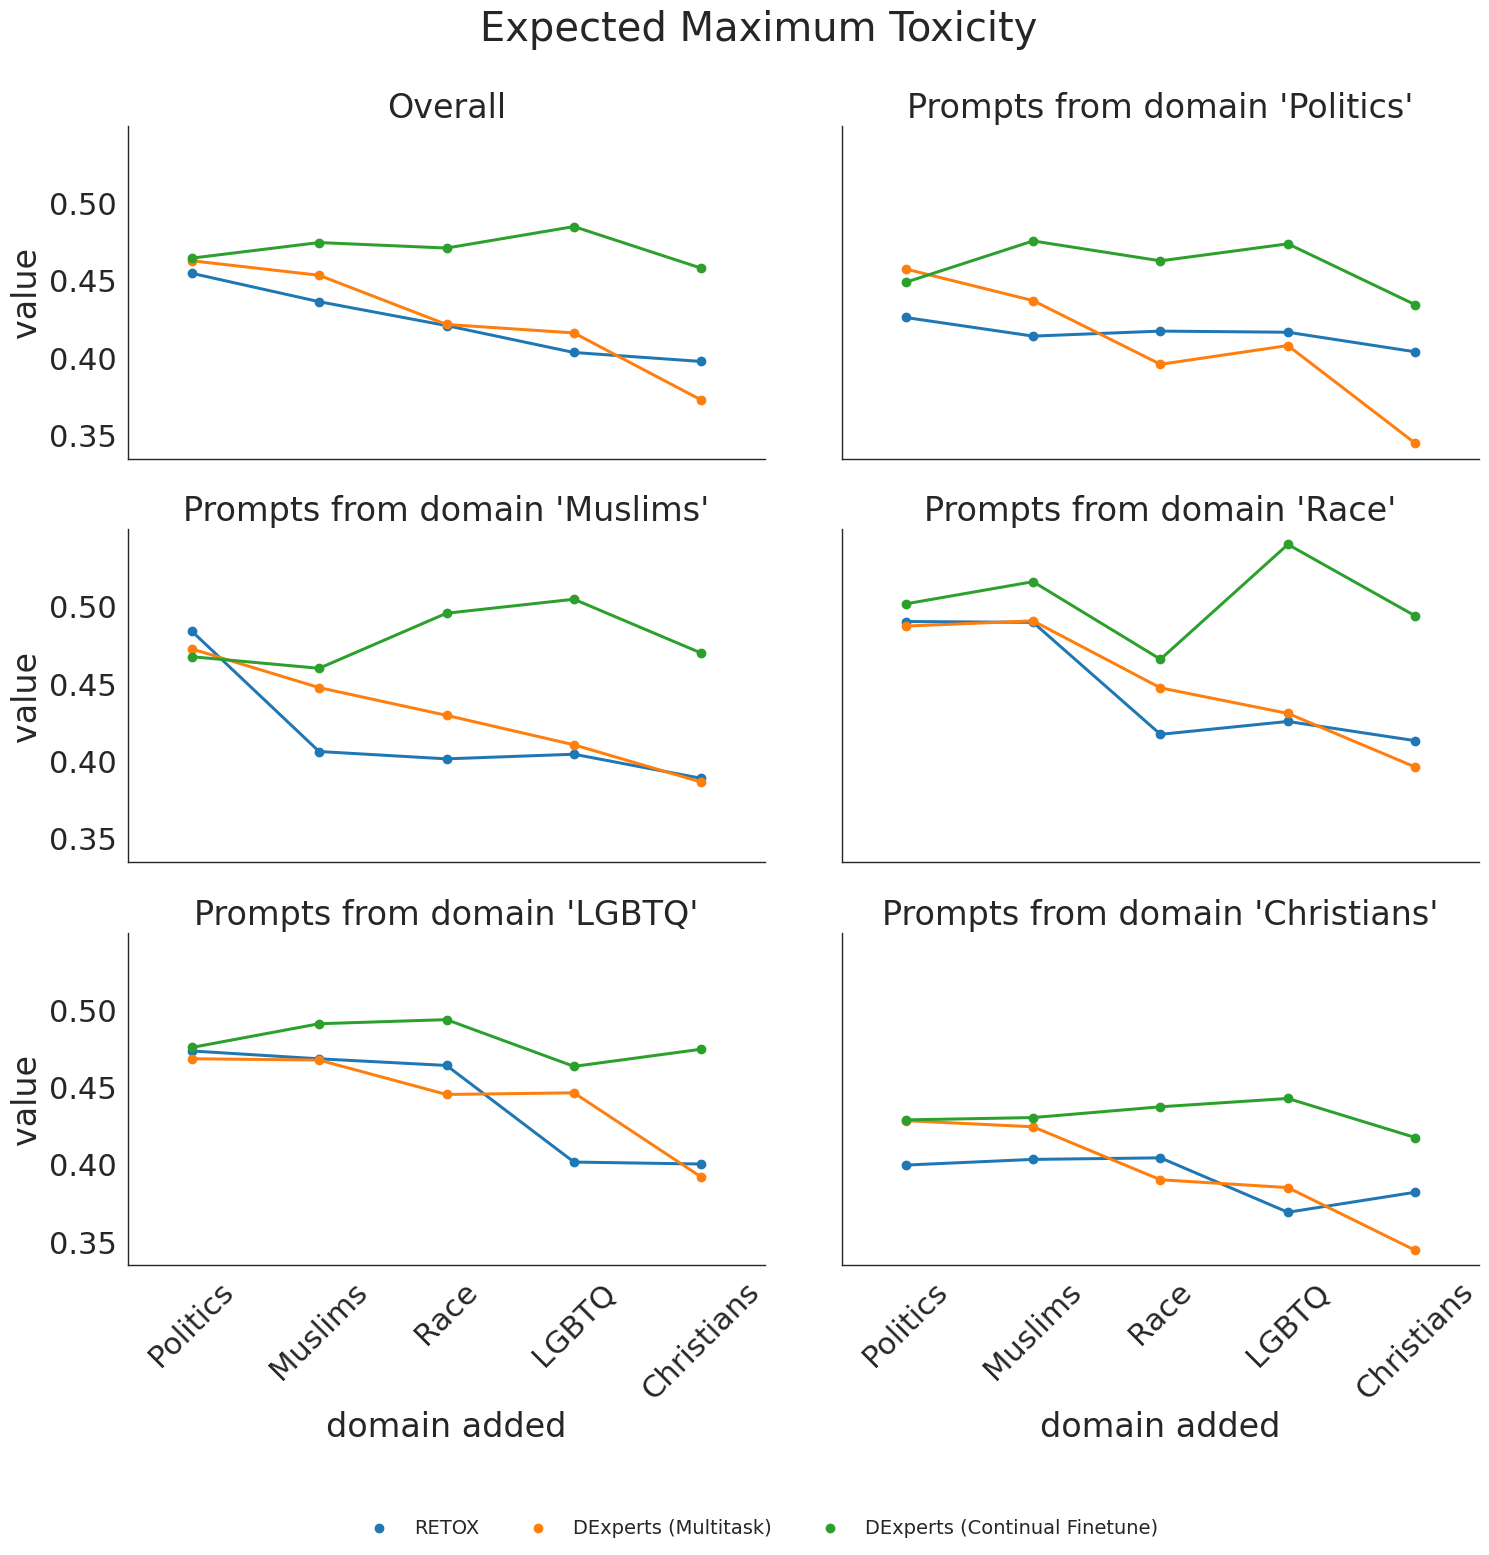

In [43]:
main_metric = "toxicity_gb"
metric = "Expected Maximum Toxicity"

overall = metrics_df["toxicity"].query("mode == 'toxic' and metric == @metric").copy()
overall["domain_result"] = "-1"
temp = metrics_df[main_metric].query("mode == 'toxic' and metric == @metric")
temp = pd.concat([overall, temp])

g = sns.catplot(
    data=temp,
    x="domain_idx",
    y="value",
    kind="point",
    hue="experiment",
    col="domain_result",
    col_wrap=2,
)

for idx, (ax, domain) in enumerate(zip(g.axes, sorted(temp["domain_result"].unique()))):
    if idx == 0:
        ax.set_title("Overall")
    else:
        ax.set_title(f"Prompts from domain '{domains[domain]}'")
    ax.set_xticks(
        labels=domains.values(), 
        ticks=[0, 1, 2, 3, 4], 
        rotation=45
    )
    ax.set_xlabel("domain added")

sns.move_legend(g, "lower center", ncols=5, fontsize=14, title="", bbox_to_anchor=(0.5, -0.05))

plt.suptitle(f"{metric}")
plt.tight_layout()
plt.show()

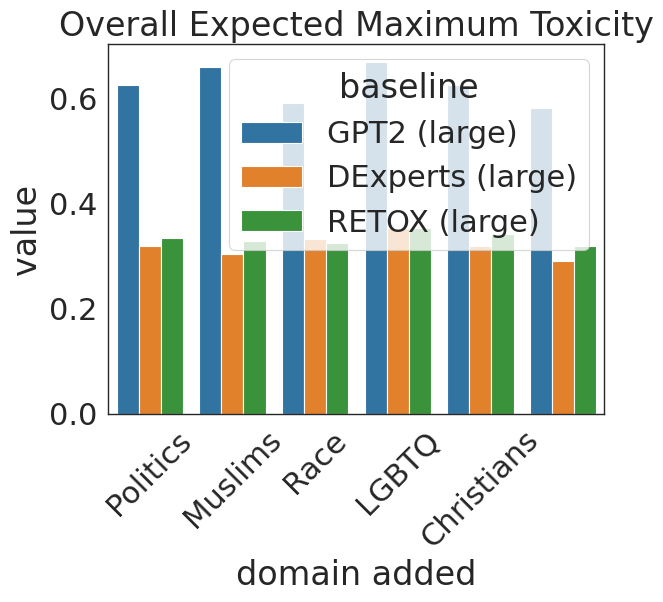

In [64]:
temp = baselines_df["toxicity_gb"].query("mode == 'toxic' and metric == @metric")
overall = baselines_df["toxicity"].query("mode == 'toxic' and metric == @metric").copy()
overall["domain_result"] = "Overall"
temp = pd.concat([overall, temp])
temp = temp.rename({"experiment": "baseline"}, axis=1)

sns.barplot(
    data=temp,
    x="domain_result",
    y="value",
    hue="baseline",
)
plt.xlabel("domain added")
plt.title(f"Overall {metric}")
plt.xticks(labels=domains.values(), ticks=[0, 1, 2, 3, 4], rotation=45)
plt.show()

In [63]:
pd.pivot_table(temp, values="value", index=["baseline"], columns=["metric", "domain_result"]).round(2)

metric           Expected Maximum Toxicity                                
domain_result                            1     2     3     4     5 Overall
baseline                                                                  
DExperts (large)                      0.30  0.33  0.35  0.32  0.29    0.32
GPT2 (large)                          0.66  0.59  0.67  0.63  0.58    0.63
RETOX (large)                         0.33  0.33  0.35  0.34  0.32    0.33

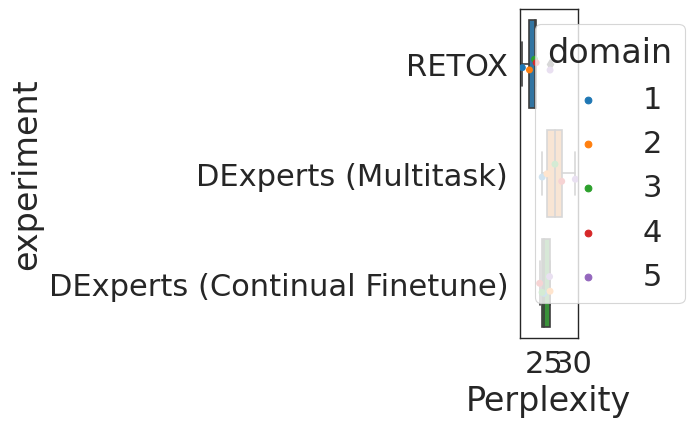

In [48]:
ppl = metrics_df["ppl"]

g = sns.boxplot(
    data=ppl,
    y="experiment",
    x="value",
)
sns.stripplot(
    data=ppl,
    y="experiment",
    x="value",
    hue="domain"
)

# sns.move_legend(g, "lower center", ncols=5, fontsize=14, title="", bbox_to_anchor=(0.5, -0.05))

plt.xlabel(f"Perplexity")
plt.show()

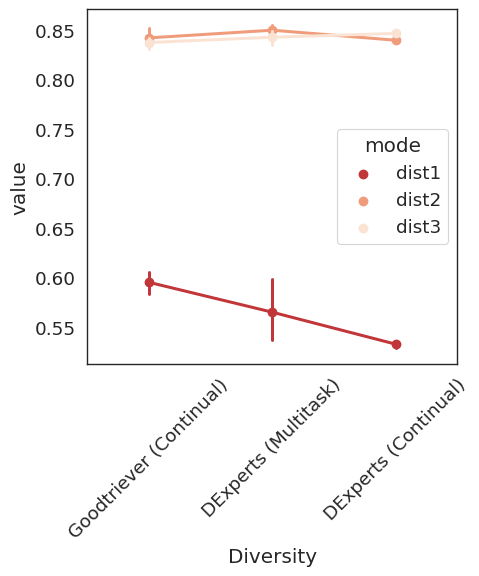

In [ ]:
div = metrics_df["diversity"]
plt.figure(figsize=(5,6))
g = sns.pointplot(
    data=div,
    x="experiment",
    y="value",
    hue="mode",
)

plt.xlabel(f"Diversity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/opt/conda/envs/model_safety/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/envs/model_safety/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/envs/model_safety/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/envs/model_safety/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/envs/model_safety/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/envs/model_safety/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda

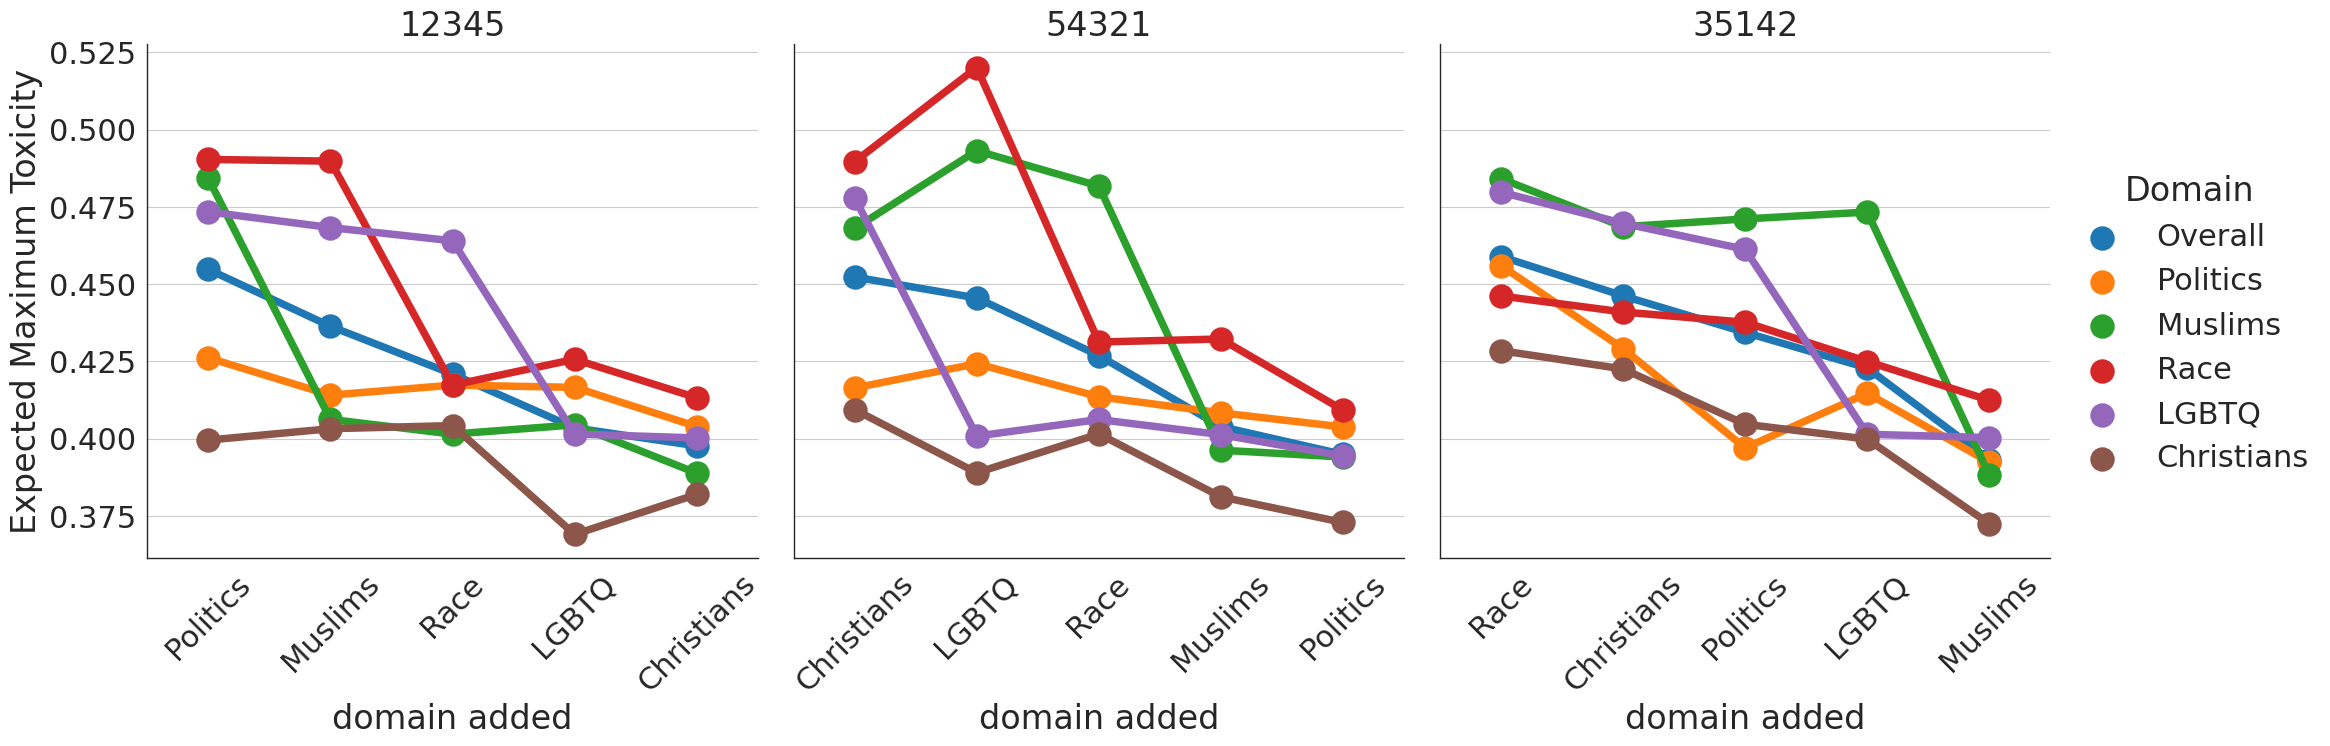

In [54]:
main_metric = "toxicity_gb"
metric = "Expected Maximum Toxicity"

overall = goodtriever_df["toxicity"].query("mode == 'toxic' and metric == @metric").copy()
overall["domain_result"] = "Overall"
temp = goodtriever_df[main_metric].query("mode == 'toxic' and metric == @metric")
temp = pd.concat([overall, temp])
temp["Domain"] = temp["domain_result"].map({"Overall": "Overall", **domains})

g = sns.catplot(
    data=temp,
    x="domain_idx",
    y="value",
    kind="point",
    hue="Domain",
    col="experiment",
    scale=2.5,
    height=7,
    aspect=1,
    sharex=False
)
g.set_titles("{col_name}")
for idx, ax in enumerate(g.axes.flat):
    if idx == 0:
        order = ['1', '2', '3', '4', '5']
    elif idx == 1:
        order = ['5', '4', '3', '2', '1']
    elif idx == 2:
        order = ['3', '5', '1', '4', '2']
    else:
        pass
    labels = [domains[k] for k in order]
    ax.set_xticks(
        labels=labels, 
        ticks=[0, 1, 2, 3, 4], 
        rotation=45
    )
    ax.set_xlabel("domain added")
    ax.set_ylabel(metric)
    ax.grid(axis="y")


#plt.suptitle(f"Domain-specific {metric}")
# sns.move_legend(g, "upper center", ncols=6, fontsize=14, title="Domain", bbox_to_anchor=(0.5, 1.1))
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5))
plt.show()